### Setup / Pre-processing

In [14]:
# general imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import io
import re

# model building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, Normalizer
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, GRU, Bidirectional, InputLayer, SimpleRNN, Dropout, Flatten, Conv1D, Input, MaxPooling1D, Embedding
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import np_utils

# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

# filepath for model saving
fp = '/content/drive/My Drive/RESEARCH/NG_DISCRIMINATION/models/'

Mounted at /content/drive


In [0]:
ols = np.load('/content/drive/My Drive/RESEARCH/NG_DISCRIMINATION/datasets/ols.npy')
wls = np.load('/content/drive/My Drive/RESEARCH/NG_DISCRIMINATION/datasets/wls.npy')

In [16]:
# 0 - ('time_stamp', np.int64),                   # the timestamp for the event
# 1 - ('baseline', np.int16),                     # the baseline for the event
# 2 - ('peak', np.int16),                         # the peak energy value for the event
# 3 - ('energy', np.int32),                       # the sum of the energy values for the event
# 4 - ('noise', np.int16),                        # the estimated noise floor for the event
# 5 - ('timeOver', np.double),                    # timeOver(Threshold)
# 6 - ('timeOverType', np.byte),                  # type (G,N,U) as determined by the timeOver(Threshold) method
# 7 - ('riseTime', np.double),                    # riseTime
# 8 - ('riseTimeType', np.byte),                  # type (G,N,U) as determined by the riseTime method
# 9 - ('qRatio', np.double),                      # qRatio
# 10 - ('qRatioType', np.byte),                    # type (G,N,U) as determined by the qRatio method
# 11 - ('values', np.int16, (self.eventLength,)),  # flipped, relative to baseline, band filtered
# 12 - ('based', np.int16, (self.eventLength,)),   # flipped, relative to baseline, not band filter
# 13 - ('raw', np.int16, (self.eventLength,))      # flipped, but otherwise unmodified values
print(wls[0][11])
print(wls.shape)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   35  820 1373 2289 1737 2571 2295 1245  691  993  953  725  605
  573  361  276  144    0   23   16   67    0   70    0   22    0   36
    0   17    0   18    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0   45   52   46    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0   19
    0    0    0    0    0    0    0  180   28   32]
(181482,)


In [17]:
# extract sequences
limit = len(wls) # to define size of subset
seqs = []
for i in range(limit):
    seqs.append(wls[i][11])
seqs = np.array(seqs)
seqs = seqs.astype('float64')
print(seqs)
seqs.shape

[[  0.   0.   0. ... 180.  28.  32.]
 [  0.   0.   0. ...  22.  29.   0.]
 [  0.   0.   0. ...   0. 266. 103.]
 ...
 [ 30.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0. 116.]
 [ 76.   0.   0. ...   0.   0.   0.]]


(181482, 150)

In [18]:
# extract labels (1 = G, 2 = N, converted to 0 & 1 for training, respectively)
labels = []
for i in range(limit):
    if ols[i][10] == 1:
        labels.append(0)
    elif ols[i][10] == 2:
        labels.append(1)
labels = np.array(labels)
print(labels)
labels.shape

[0 0 0 ... 0 1 0]


(181482,)

In [19]:
# split into training & test sets
xtrain, xtest, ytrain, ytest = train_test_split(seqs, labels, test_size = .2, shuffle = True)

print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape)

(145185, 150) (145185,) (36297, 150) (36297,)


In [20]:
# normalize training sequences
normalizer = Normalizer(copy = False).fit(xtrain) # saves L2 normalization parameters for xtrain
n_xtrain = normalizer.transform(xtrain)
n_xtest = normalizer.transform(xtest) # normalizes test data with same parameters as training data
n_xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))
n_xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))
print(n_xtrain.shape, n_xtest.shape)

(145185, 150, 1) (36297, 150, 1)


### Model Creation

In [22]:
# create model
model = Sequential()
model.add(GRU(8, input_shape = (150, 1), return_sequences = True))
model.add(GRU(8, return_sequences = True))
model.add(GRU(8, return_sequences = True))
model.add(GRU(8))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 150, 8)            240       
_________________________________________________________________
gru_11 (GRU)                 (None, 150, 8)            408       
_________________________________________________________________
gru_12 (GRU)                 (None, 150, 8)            408       
_________________________________________________________________
gru_13 (GRU)                 (None, 8)                 408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________


In [0]:
# callback list
A = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 10, min_delta = .0001, restore_best_weights=True)

B = ModelCheckpoint(filepath = fp + 'WLS_2xGRU(8)_60.hdf5', save_best_only = True, verbose = 1, monitor = 'val_accuracy', mode = 'max', )

cb_list = [A, B]

In [0]:
# fit model
history = model.fit(n_xtrain, ytrain, validation_split = .25, shuffle = True, batch_size = 16, 
                    epochs = 100, verbose = 1, callbacks = cb_list)

Train on 108888 samples, validate on 36297 samples
Epoch 1/100
108888/108888 [==============================] - 726s 7ms/step - loss: 0.4827 - accuracy: 0.8049 - val_loss: 0.4452 - val_accuracy: 0.8049

Epoch 00001: val_accuracy improved from -inf to 0.80492, saving model to /content/drive/My Drive/RESEARCH/NG_DISCRIMINATION/models/WLS_2xGRU(8)_60.hdf5
Epoch 2/100
108888/108888 [==============================] - 724s 7ms/step - loss: 0.4082 - accuracy: 0.8214 - val_loss: 0.4033 - val_accuracy: 0.8235

Epoch 00002: val_accuracy improved from 0.80492 to 0.82348, saving model to /content/drive/My Drive/RESEARCH/NG_DISCRIMINATION/models/WLS_2xGRU(8)_60.hdf5
Epoch 3/100
108888/108888 [==============================] - 737s 7ms/step - loss: 0.3945 - accuracy: 0.8302 - val_loss: 0.4388 - val_accuracy: 0.8020

Epoch 00003: val_accuracy did not improve from 0.82348
Epoch 4/100
108888/108888 [==============================] - 730s 7ms/step - loss: 0.3809 - accuracy: 0.8362 - val_loss: 0.3893 - v

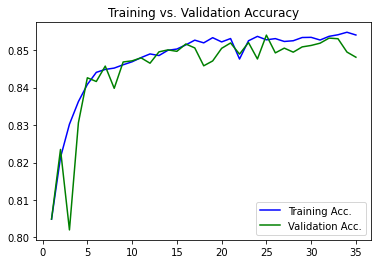

Maximum Validation Accuracy: 0.8539824485778809


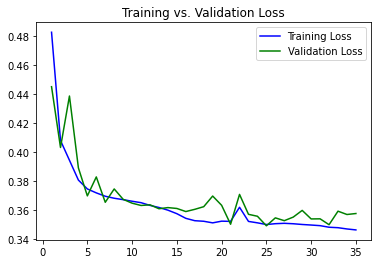

Minimum Validation Loss: 0.3494247167774589


In [0]:
# Plot training/validation accuracy
acc = history.history['accuracy']
vacc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training Acc.')
plt.plot(epochs, vacc, 'g', label = 'Validation Acc.')
plt.title ('Training vs. Validation Accuracy')
plt.legend()
plt.show()

print('Maximum Validation Accuracy: ' + str(max(history.history['val_accuracy'])))

# Plot training/validation loss
loss = history.history['loss']
vloss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, vloss, 'g', label = 'Validation Loss')
plt.title ('Training vs. Validation Loss')
plt.legend()
plt.show()

print('Minimum Validation Loss: ' + str(min(history.history['val_loss'])))

### Model Evaluation

In [0]:
# Load Model
trained_model = load_model((fp + 'WLS_2xGRU(8)_60.hdf5'))

In [0]:
# evaluate on test data (normalized with same parameters as training data)
results = trained_model.evaluate(x = n_xtest, y = ytest, batch_size = 16, verbose = 1)
print('test loss, test acc:', results)

36297/36297 [==============================] - 35s 954us/step
test loss, test acc: [0.34224642575383235, 0.8534038662910461]


In [0]:
# generate predictions on subset of test data (for direct comparison)
n = 35
predictions = trained_model.predict(n_xtest[:n])
print('predictions shape:', predictions.shape)
print("preds: ", np.around(predictions).reshape(1,n).astype(int)[0])
print("label: ", ytest[:n])

predictions shape: (35, 1)
preds:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0]
label:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0]


### Experiment Log

*   WLS-trained Model (16APR20) - BASELINE
  *   2xGRU(8)
  *   60% train, 20% val, 20% test
  *   vloss, vacc: 0.3494247167774589, 0.8539824485778809  
  *   tloss, tacc: 0.34224642575383235, 0.8534038662910461
*   Improvements to Try:
  *   HARDCODE RANDOM STATE VALUE TO ISOLATE NORMALIZATION PARAMETERS FOR FUTURE EVALUATION
  *   Reduce learning rate on plateau, to address erratic descent
  *   L1 normalization
  *   Switch to SimpleRNN/LSTM/Bidirectional
  *   Train/Val/Test Split (80/10/10, 90/5/5)
  *   Lower batch size
  *   Change optimizer
  *   Taller network
  *   Deeper network 





